In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
import tensorflow as tf
from pathlib import Path
from time import time, strftime
from shutil import rmtree
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
#matplotlib.use("TKAgg", force=True)
%matplotlib inline
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from rtapipe.lib.utils.misc import dotdict
from rtapipe.lib.dataset.data_manager import DataManager
from rtapipe.lib.datasource.Photometry3 import OnlinePhotometry, SimulationParams
from rtapipe.lib.plotting.plotting import plot_sequences, plot_nn_metrics
from rtapipe.lib.models.anomaly_detector_builder import AnomalyDetectorBuilder
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma
from rtapipe.lib.standardanalysis.li_ma import LiMa
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma, get_sigma_from_pvalue, get_sigma_for_ts_array, get_sigma_from_ts
from rtapipe.lib.utils.notebook import *
from sagsci.tools.utils import get_obs_pointing
from sagsci.wrappers.rtaph.photometry import Photometrics

# Loading the models

In [3]:
def load_model(model_id):
    with open("./trained_models.yaml", "r") as f:
        try:
            configs = yaml.safe_load(f)
        except yaml.YAMLError as exc:
            print(exc)
    model_config = [c for c in configs["models"] if c["id"] == model_id]
    model_config = dotdict(model_config.pop())
    model_config.ad = AnomalyDetectorBuilder.getAnomalyDetector(name=model_config.name, timesteps=model_config.timesteps, nfeatures=model_config.nfeatures, load_model="True", training_epoch_dir=model_config.path, training=False)
    model_config.pvalue_table = get_pval_table(model_config.pval_path) 
    return model_config

In [4]:
model_config_cnn = load_model(6)
model_config_cnn

AnomalyDetector_cnn_l2_u32 - input shape: (5,3)


{'id': 6,
 'patience': 5,
 'integrationtime': 1,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_cnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5',
 'epoch': 5,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5/pvalues/pval_20221227-100500/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/fitted_scaler_minmax_itime_1_tsl_500.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_cnn.AnomalyDetector_cnn_l2_u32 at 0x2b85d74fbca0>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.002693       0.000204  1.024

In [5]:
model_config_rnn = load_model(7)
model_config_rnn

AnomalyDetector_rnn_l2_u32 - input shape: (5,3)


{'id': 7,
 'patience': 5,
 'integrationtime': 1,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_rnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5',
 'epoch': 5,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5/pvalues/pval_20221222-114342/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/fitted_scaler_minmax_itime_1_tsl_500.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_rnn.AnomalyDetector_rnn_l2_u32 at 0x2b85dae90df0>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.000201       0.000015  1.339

# Loading the test dataset

In [6]:
output_dir = "./logs/test_models_dataset_test_set_all_itime_1"

In [7]:
features_names = ["EB_0.04-0.117","EB_2-0.117-0.342","EB_0.342-1"]

In [8]:
data_manager = DataManager(output_dir)

In [9]:
dataset_folder = "/data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/test/test_set_all/fits_data"
fits_files = DataManager.load_fits_data(dataset_folder, limit=500)
test_set_size = len(fits_files)

Loaded 419 files


In [10]:
sim_params = SimulationParams(runid=None, onset=250, emin=0.04, emax=1, tmin=0, tobs=500, offset=0.5, irf="North_z40_5h_LST", roi=2.5, caldb="prod5-v0.1", simtype="grb")
multiple_templates = True
add_target_region = True
integration_time = 1
number_of_energy_bins = 3
tsl = 500
threads = 30
normalize = True
#data_manager.transform_to_timeseries(fits_files, sim_params, add_target_region, integration_time=integration_time, number_of_energy_bins=number_of_energy_bins, tsl=tsl, normalize=normalize, threads=threads, multiple_templates=multiple_templates)
data_manager.load_saved_data(1, 5)

[2023-01-28 11:37:02.604987] Loaded data from logs/test_models_dataset_test_set_all_itime_1/data_cache. Loaded 419 templates.


In [11]:
assert len(data_manager.data.keys()) == test_set_size

## Plot some samples

In [12]:
#for template in list(data_manager.data.keys())[0:5]:
#    data_manager.plot_timeseries(template, data_manager.data[template], 1, sim_params, output_dir, labels=features_names)

# TESTING

In [13]:
data_manager.load_scaler(model_config_rnn.scaler_path) # model_config_rnn.scaler_path or model_config_cnn.scaler_path

In [14]:
test_all_x, test_all_y = data_manager.get_test_set_all_templates(verbose=False, onset=250, integration_time=integration_time, sub_window_size=5, stride=1)

[2023-01-28 11:37:05.697075] Total x shape shape: (207824, 5, 3)
[2023-01-28 11:37:05.697238] Total y shape shape: (207824,)


In [15]:
test_all_y.sum()

104331

# P-values table

In [47]:
tmpdf=model_config_rnn.pvalue_table.drop(["threshold_err"], axis=1)
tmpdf

threshold        pvalue    pvalue_err  sigma
0    0.000201  1.339528e-01  1.245178e-04  1.108
1    0.000231  9.240326e-02  1.034188e-04  1.326
2    0.000261  5.839725e-02  8.221515e-05  1.568
3    0.000291  3.584189e-02  6.440968e-05  1.801
4    0.000322  2.368679e-02  5.236110e-05  1.983
..        ...           ...           ...    ...
89   0.002895  1.157474e-07  1.157474e-07  5.172
90   0.002925  1.157474e-07  1.157474e-07  5.172
91   0.002956  1.157474e-07  1.157474e-07  5.172
92   0.002986  1.157474e-07  1.157474e-07  5.172
93   0.003016  1.157474e-07  1.157474e-07  5.172

[94 rows x 4 columns]

In [ ]:
tmpdf=model_config_rnn.pvalue_table.drop_duplicates(subset=['sigma'])
tmpdf=model_config_rnn.pvalue_table.drop(["threshold_err"], axis=1)

tmpdf=tmpdf.loc[
    (tmpdf['sigma'] > 0.99)   & 
    (tmpdf['sigma'] < 1.1) |
    (tmpdf['sigma'] > 1.4) &
    (tmpdf['sigma'] < 1.6) |
    (tmpdf['sigma'] > 1.9) &
    (tmpdf['sigma'] < 2.1) |
    (tmpdf['sigma'] > 2.4) &
    (tmpdf['sigma'] < 2.6) |
    (tmpdf['sigma'] > 2.9) &
    (tmpdf['sigma'] < 3.1) |
    (tmpdf['sigma'] > 3.4) &
    (tmpdf['sigma'] < 3.6) |
    (tmpdf['sigma'] > 3.9) &
    (tmpdf['sigma'] < 4.1) |
    (tmpdf['sigma'] > 4.4) &
    (tmpdf['sigma'] < 4.6) | 
    (tmpdf['sigma'] > 4.9) &
    (tmpdf['sigma'] < 5.1) 
]


tmpdf.to_latex("pvalue_table_rnn.tex")
! cat pvalue_table.tex

## CNN

In [ ]:
tmpdf=model_config_cnn.pvalue_table.drop(["threshold_err"], axis=1)
tmpdf

In [50]:
tmpdf=model_config_cnn.pvalue_table.drop_duplicates(subset=['sigma'])
tmpdf=model_config_cnn.pvalue_table.drop(["threshold_err"], axis=1)

tmpdf=tmpdf.loc[
    (tmpdf['sigma'] > 0.99)   & 
    (tmpdf['sigma'] < 1.1) |
    (tmpdf['sigma'] > 1.4) &
    (tmpdf['sigma'] < 1.6) |
    (tmpdf['sigma'] > 1.9) &
    (tmpdf['sigma'] < 2.1) |
    (tmpdf['sigma'] > 2.4) &
    (tmpdf['sigma'] < 2.6) |
    (tmpdf['sigma'] > 2.9) &
    (tmpdf['sigma'] < 3.1) |
    (tmpdf['sigma'] > 3.4) &
    (tmpdf['sigma'] < 3.6) |
    (tmpdf['sigma'] > 3.9) &
    (tmpdf['sigma'] < 4.1) |
    (tmpdf['sigma'] > 4.4) &
    (tmpdf['sigma'] < 4.6) | 
    (tmpdf['sigma'] > 4.9) &
    (tmpdf['sigma'] < 5.1) 
]


tmpdf.to_latex("pvalue_table_cnn.tex")
! cat pvalue_table.tex

\begin{tabular}{lrrrr}
\toprule
{} &  threshold &        pvalue &    pvalue\_err &  sigma \\
\midrule
0  &   0.003171 &  1.283972e-01 &  1.201785e-04 &  1.134 \\
4  &   0.003751 &  6.115264e-02 &  8.293861e-05 &  1.545 \\
9  &   0.004476 &  2.277199e-02 &  5.061155e-05 &  2.000 \\
16 &   0.005492 &  5.323285e-03 &  2.447028e-05 &  2.554 \\
23 &   0.006507 &  1.228234e-03 &  1.175411e-05 &  3.029 \\
31 &   0.007667 &  2.312711e-04 &  5.100465e-06 &  3.502 \\
41 &   0.009118 &  3.149606e-05 &  1.882250e-06 &  4.001 \\
53 &   0.010859 &  3.262092e-06 &  6.057553e-07 &  4.509 \\
73 &   0.013760 &  4.499438e-07 &  2.249719e-07 &  4.912 \\
74 &   0.013905 &  2.249719e-07 &  1.590791e-07 &  5.047 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_216675/105189838.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tmpdf.to_latex("pvalue_table_cnn.tex")


# RNN

In [18]:
metrics_rnn = evaluate_metrics(model_config_rnn, test_all_x, test_all_y, output_dir, "metrics_rnn.pickle", additional_tresholds=[0.000025, 0.000050, 0.000075])

Using threshold 2.5e-05
Using threshold 5e-05
Using threshold 7.5e-05
Using threshold 0.000200540347
Using threshold 0.000351921537
Using threshold 0.000806065107
Using threshold 0.001260208677
Using threshold 0.002622639387
Generating output file:  logs/test_models_dataset_test_set_all_itime_1/metrics_rnn.pickle


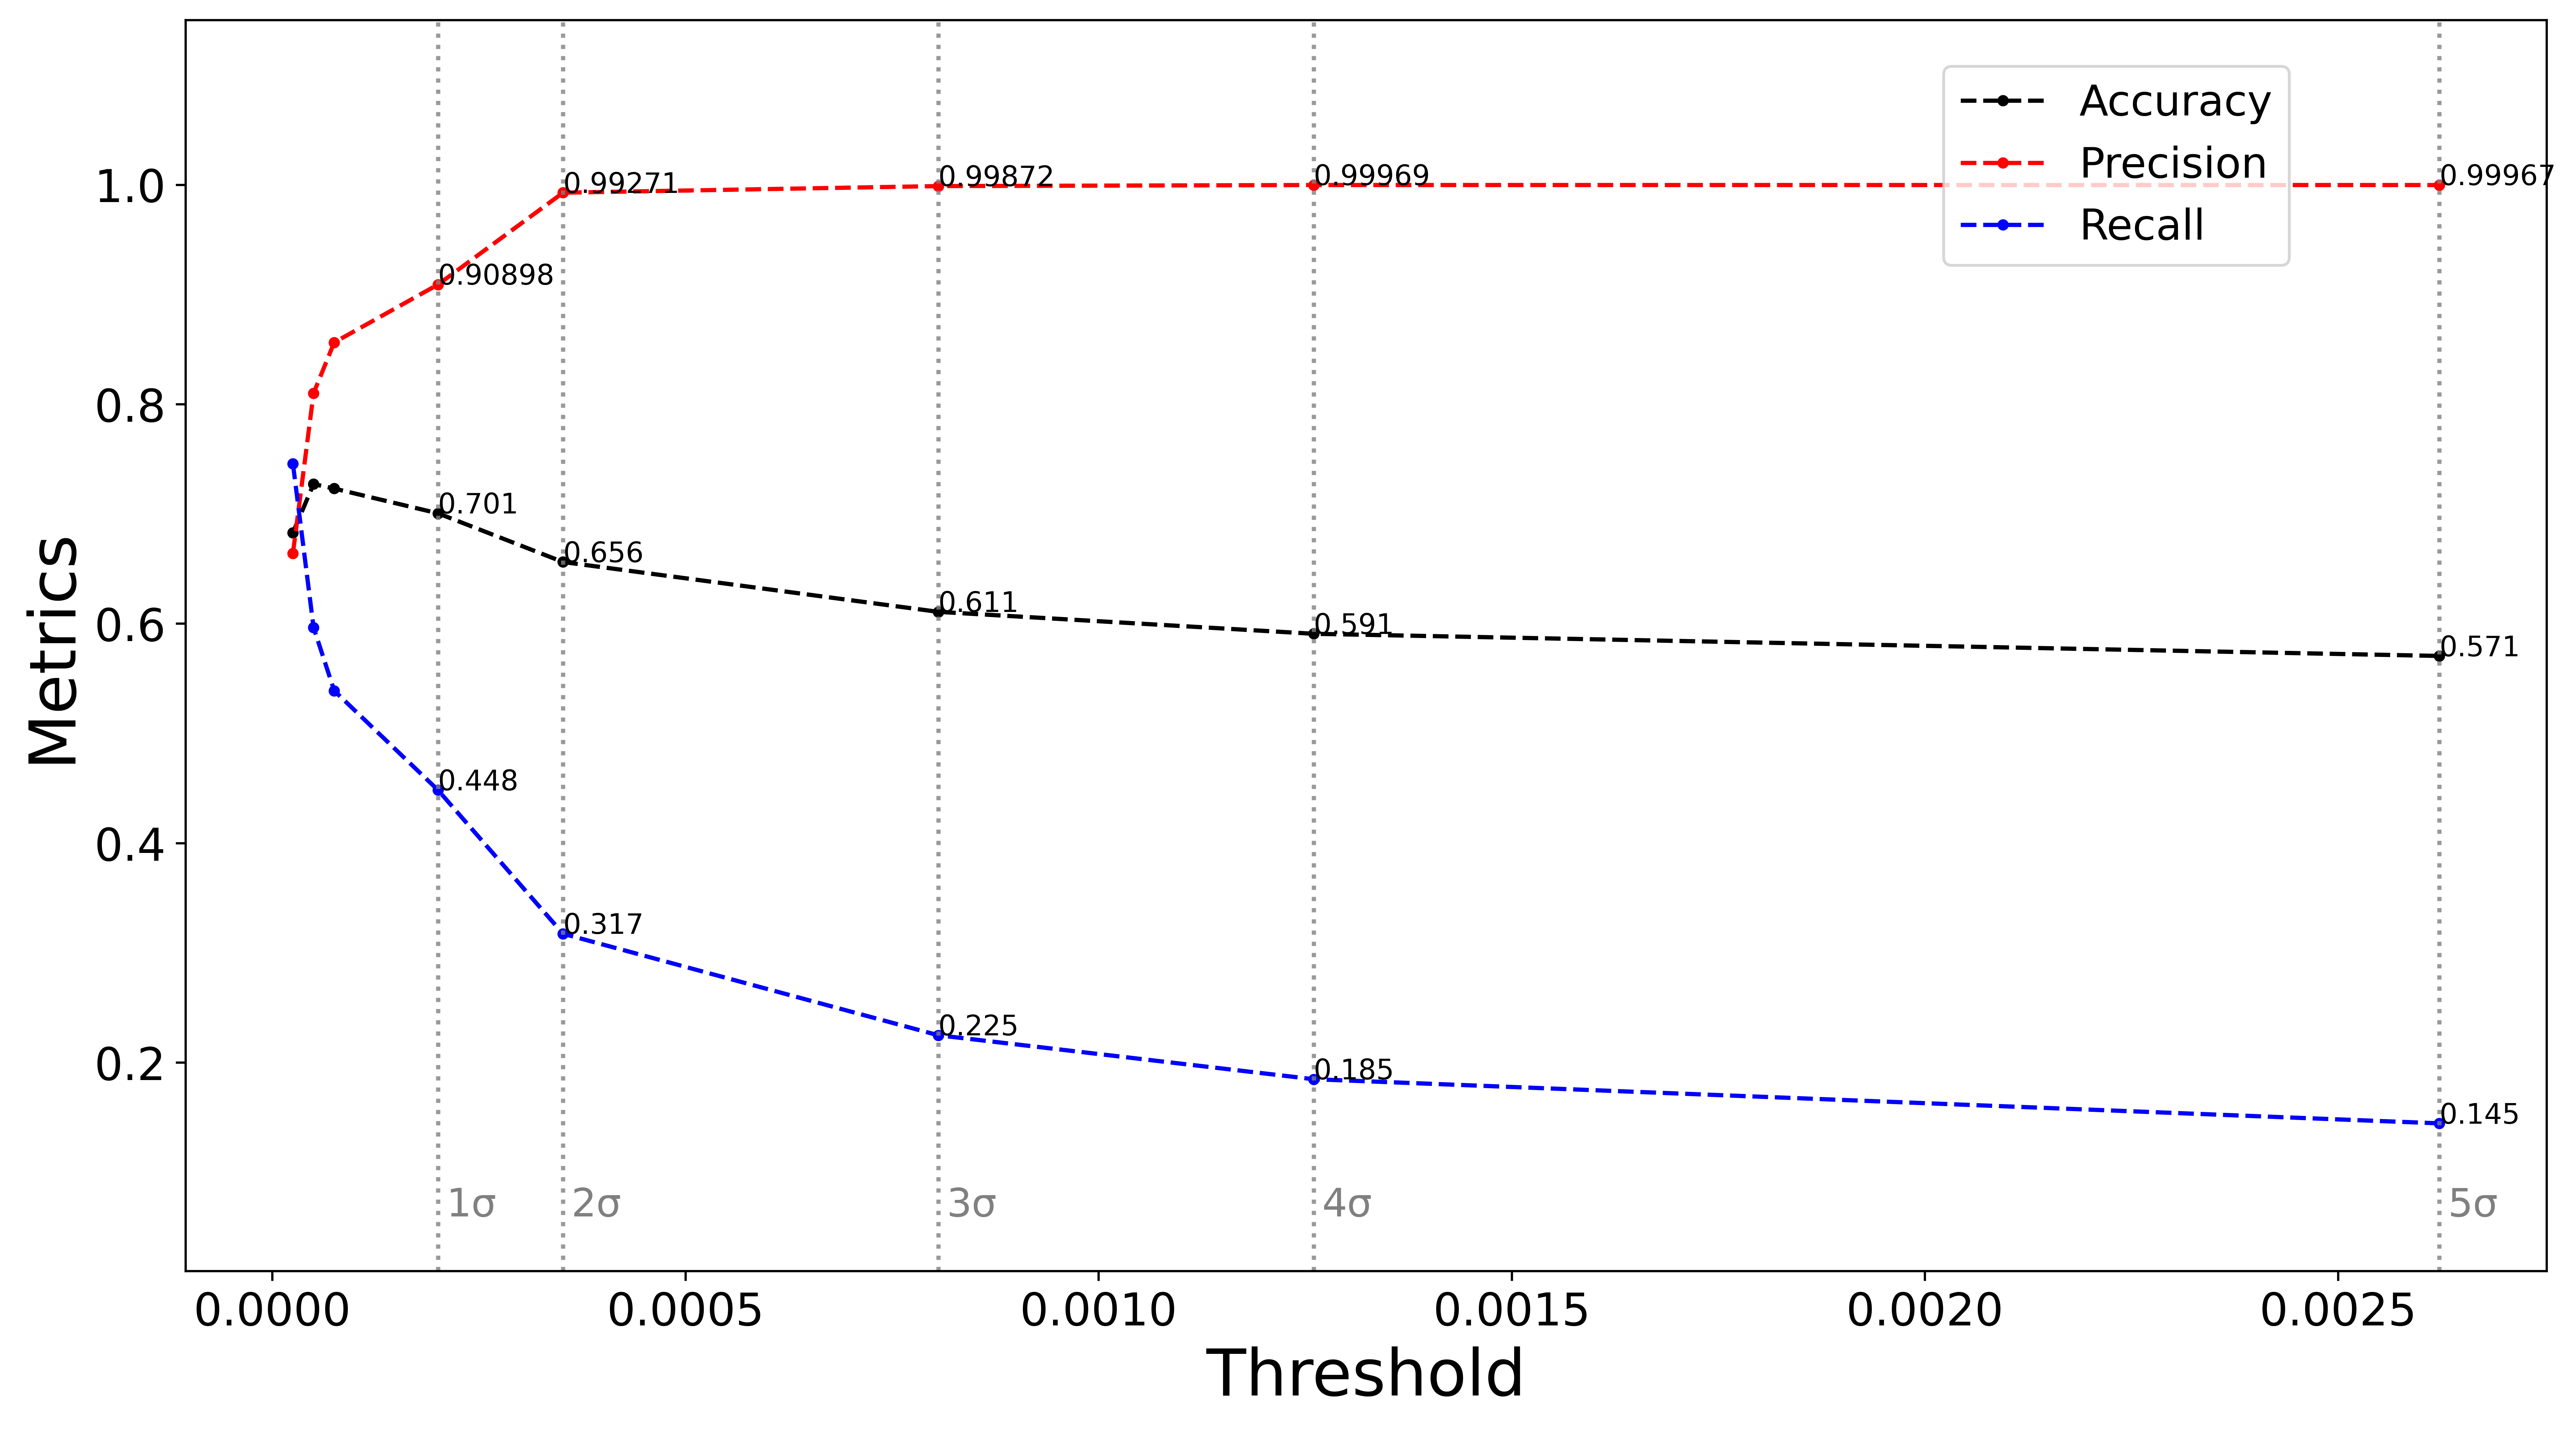

Saved figure to:  logs/test_models_dataset_test_set_all_itime_1/rnn_metrics_test_set_all_itime_1.png


In [19]:
%matplotlib inline
plot_nn_metrics(metrics_rnn, model_config_rnn, output_dir, fig_name="rnn_metrics_test_set_all_itime_1", y_lim=(0.01, 1.15), annotate_after=3, showFig=True, saveFig=True)

## Standard metrics - 5 sigma threshold

In [20]:
SIGMA_THRESHOLD = 5

In [21]:
sigma_threshold = get_threshold_for_sigma(model_config_rnn.pvalue_table, SIGMA_THRESHOLD)
model_config_rnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_rnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_rnn.pvalue_table, model_config_rnn.ad.threshold)} sigma")

Threshold: 0.002622639387 corresponding to 5.0410478147 sigma


In [22]:
print(f"************** Evaluating {model_config_rnn.name} patience={model_config_rnn.patience} **************")
metrics = model_config_rnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_rnn.ad.detection_delay(test_all_y, model_config_rnn.ad.predict(test_all_x), test_set_size, model_config_rnn.timesteps))

************** Evaluating AnomalyDetector_rnn_l2_u32 patience=5 **************
Using threshold 0.002622639387
accuracy 0.5705500808376318
precision 0.9996686766947187
recall 0.14459748301080216
f1 0.25265026544522784
roc_auc 0.5722745852822749
confusion_matrix [[103488, 5], [89245, 15086]]
false_positive_rate 0.0003313233052812935
detection_delay: 12.221957040572793


## Sigma table

In [23]:
def crop_to_5(s):
    if s > 5: 
        s = 5.00001
    return s

In [24]:
data = {}
for template in tqdm(list(data_manager.data.keys())):
    test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=1, sub_window_size=5, stride=1)
    model_config_rnn.ad.predict(test_x)
    data[template] = get_sigma_for_ts_array(model_config_rnn.pvalue_table, model_config_rnn.ad.get_reconstruction_errors(), verbose=False)

sigma_table_rnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(496, 1, 5, 1))    
sigma_table_rnn = sigma_table_rnn.applymap(crop_to_5)

100%|██████████| 419/419 [01:37<00:00,  4.32it/s]


In [25]:
sigma_table_rnn.to_csv(Path(output_dir).joinpath("sigma_table_rnn_test_set_all_itime_1.csv"))

In [26]:
sigma_table_rnn

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-5                   0.0               0.0          0.000000   
1-6                   0.0               0.0          0.000000   
2-7                   0.0               0.0          0.000000   
3-8                   0.0               0.0          0.000000   
4-9                   0.0               0.0          0.000000   
...                   ...               ...               ...   
491-496               0.0               0.0          1.288220   
492-497               0.0               0.0          0.000000   
493-498               0.0               0.0          0.000000   
494-499               0.0               0.0          1.551745   
495-500               0.0               0.0          0.000000   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-5                   0.0          0.000000               0.0   
1-6                   0.0          0.000000               0.0   
2-7                   0.0          0.000000               0.0   
3-8                   0.0          0.000000               0.0   
4-9                   0.0          0.000000               0.0   
...                   ...               ...               ...   
491-496               0.0          0.000000               0.0   
492-497               0.0          0.000000               0.0   
493-498               0.0          3.152815               0.0   
494-499               0.0          3.011202               0.0   
495-500               0.0          2.905623               0.0   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-5                   0.0          0.000000               0.0   
1-6                   0.0          0.000000               0.0   
2-7                   0.0          0.000000               0.0   
3-8                   0.0          0.000000               0.0   
4-9                   0.0          0.000000               0.0   
...                   ...               ...               ...   
491-496               0.0          2.627351               0.0   
492-497               0.0          2.380701               0.0   
493-498               0.0          0.000000               0.0   
494-499               0.0          0.000000               0.0   
495-500               0.0          1.468800               0.0   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-5              0.000000          1.689456               0.0   
1-6              0.000000          0.000000               0.0   
2-7              1.152309          0.000000               0.0   
3-8              0.000000          0.000000               0.0   
4-9              1.124724          0.000000               0.0   
...                   ...               ...               ...   
491-496          3.623377          0.000000               0.0   
492-497          5.000010          0.000000               0.0   
493-498          5.000010          1.267105               0.0   
494-499          5.000010          2.272113               0.0   
495-500          5.000010          1.838273               0.0   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-5                   0.0          0.000000               0.0   
1-6                   0.0          0.000000               0.0   
2-7                   0.0          0.000000               0.0   
3-8                   0.0          0.000000               0.0   
4-9                   0.0          0.000000               0.0   
...                   ...               ...               ...   
491-496               0.0          0.000000               0.0   
492-497               0.0          0.000000               0.0   
493-498               0.0          0.000000               0.0   
494-499               0.0          0.000000               0.0   
495-500               0.0          1.136226               0.0   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-5                   0.0              

# CNN

In [27]:
metrics_cnn = evaluate_metrics(model_config_cnn, test_all_x, test_all_y, output_dir, "metrics_cnn.pickle", additional_tresholds=[0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.002])

Using threshold 0.0001
Using threshold 0.0003
Using threshold 0.0005
Using threshold 0.0008
Using threshold 0.001
Using threshold 0.002
Using threshold 0.0026930404485
Using threshold 0.0047319747935
Using threshold 0.0092176303525
Using threshold 0.0185967283394999
Using threshold 0.0316459081475
Generating output file:  logs/test_models_dataset_test_set_all_itime_1/metrics_cnn.pickle


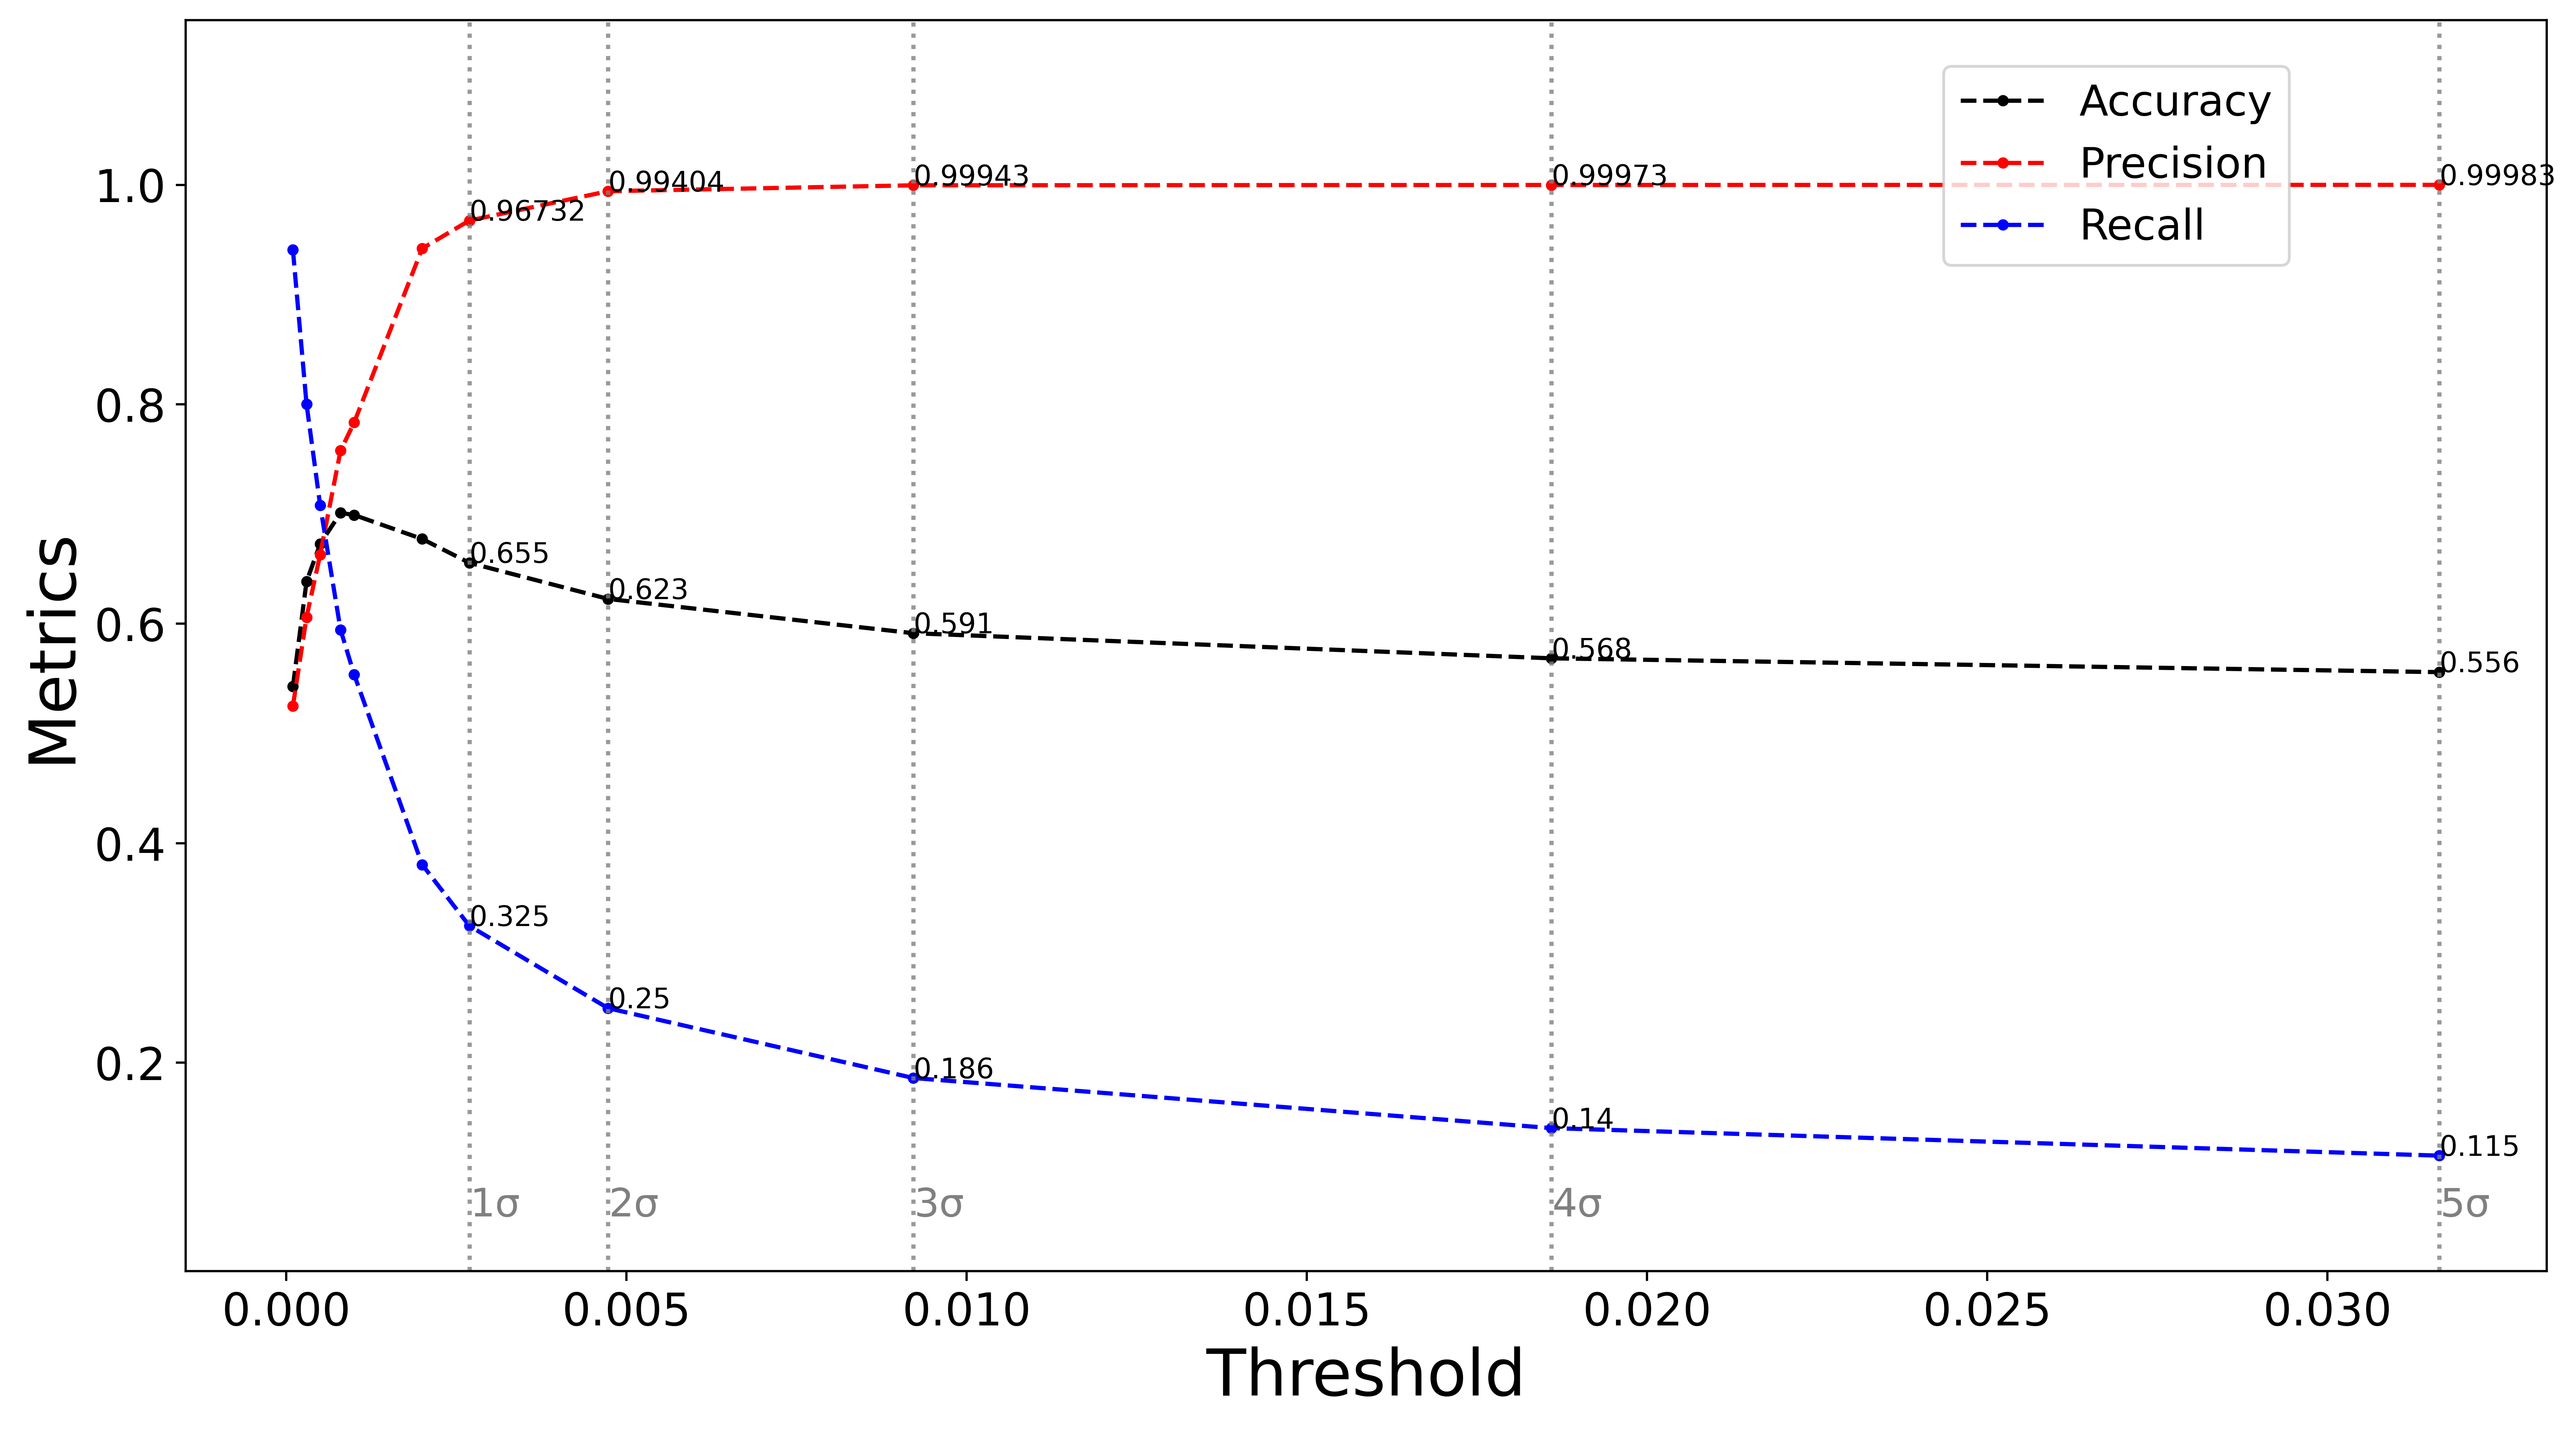

Saved figure to:  logs/test_models_dataset_test_set_all_itime_1/cnn_metrics_test_set_all_itime_1.png


In [28]:
plot_nn_metrics(metrics_cnn, model_config_cnn, output_dir, fig_name="cnn_metrics_test_set_all_itime_1", annotate_after=6, y_lim=(0.01, 1.15), showFig=True, saveFig=True)

## Standard metrics - 5 sigma

In [29]:
SIGMA_THRESHOLD = 5

In [30]:
sigma_threshold = get_threshold_for_sigma(model_config_cnn.pvalue_table, SIGMA_THRESHOLD)
model_config_cnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_cnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_cnn.pvalue_table, model_config_cnn.ad.threshold)} sigma")

Threshold: 0.0316459081475 corresponding to 5.0488536162 sigma


In [31]:
print(f"************** Evaluating {model_config_cnn.name} patience={model_config_cnn.patience} **************")
metrics = model_config_cnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_cnn.ad.detection_delay(test_all_y, model_config_cnn.ad.predict(test_all_x), test_set_size, model_config_cnn.timesteps))

************** Evaluating AnomalyDetector_cnn_l2_u32 patience=5 **************
Using threshold 0.0316459081475
accuracy 0.5557924012626069
precision 0.999833582958895
recall 0.11517190480298281
f1 0.20655098024048338
roc_auc 0.557576289912241
confusion_matrix [[103491, 2], [92315, 12016]]
false_positive_rate 0.00016641704110500916
detection_delay: 8.252983293556087


## Sigma table

In [32]:
data = {}
for template in tqdm(list(data_manager.data.keys())):
    test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=1, sub_window_size=5, stride=1)
    model_config_cnn.ad.predict(test_x)
    data[template] = get_sigma_for_ts_array(model_config_cnn.pvalue_table, model_config_cnn.ad.get_reconstruction_errors(), verbose=False)

sigma_table_cnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(496, 1, 5, 1))    
sigma_table_cnn = sigma_table_cnn.applymap(crop_to_5)

100%|██████████| 419/419 [01:06<00:00,  6.30it/s]


In [33]:
sigma_table_cnn.to_csv(Path(output_dir).joinpath("sigma_table_cnn_test_set_all_itime_1.csv"))

In [34]:
sigma_table_cnn

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-5                   0.0           0.00000               0.0   
1-6                   0.0           0.00000               0.0   
2-7                   0.0           0.00000               0.0   
3-8                   0.0           0.00000               0.0   
4-9                   0.0           0.00000               0.0   
...                   ...               ...               ...   
491-496               0.0           0.00000               0.0   
492-497               0.0           0.00000               0.0   
493-498               0.0           0.00000               0.0   
494-499               0.0           2.26826               0.0   
495-500               0.0           0.00000               0.0   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-5                   0.0          0.000000               0.0   
1-6                   0.0          0.000000               0.0   
2-7                   0.0          0.000000               0.0   
3-8                   0.0          0.000000               0.0   
4-9                   0.0          0.000000               0.0   
...                   ...               ...               ...   
491-496               0.0          2.133215               0.0   
492-497               0.0          1.810487               0.0   
493-498               0.0          0.000000               0.0   
494-499               0.0          0.000000               0.0   
495-500               0.0          1.511472               0.0   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-5              0.000000          0.000000           0.00000   
1-6              0.000000          0.000000           0.00000   
2-7              0.000000          0.000000           0.00000   
3-8              0.000000          0.000000           0.00000   
4-9              0.000000          0.000000           1.27568   
...                   ...               ...               ...   
491-496          3.087154          0.000000           0.00000   
492-497          3.409015          0.000000           0.00000   
493-498          4.314415          0.000000           0.00000   
494-499          3.417620          0.000000           0.00000   
495-500          4.753413          1.642906           0.00000   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-5                   0.0              

# Li&Ma

In [35]:
sigma_table_rnn.index.values.shape

(496,)

In [36]:
li_ma_data = {}
templates = list(data_manager.data.keys())
#templates = []

LiMa_detect_p = partial(LiMa.detect, "binned", integration_time, 9999, sigma_table_rnn.index.values, 500, 0, False, 0.2, [0.03, 1])
start = time()
with multiprocessing.Pool() as p:
    values = p.map(LiMa_detect_p, [DataManager.get_fits_from_template(fits_files, template) for template in templates])

for i, template in enumerate(templates):
     li_ma_data[template] = values[i]["sigma"].values   

print(f"Took {time()-start} s")
    
#
lima_sigma_table = pd.DataFrame(li_ma_data, index=sigma_table_rnn.index.values)
if len(templates) > 0:
    lima_sigma_table.to_csv(Path(output_dir).joinpath("sigma_table_li_ma_test_set_all_itime_1.csv"))    

Took 498.52242517471313 s


In [37]:
! mv $output_dir/sigma_table_li_ma_itime_1_dataset_e.csv $output_dir/sigma_table_li_ma_test_set_all_itime_1.csv 

mv: cannot stat ‘./logs/test_models_dataset_test_set_all_itime_1/sigma_table_li_ma_itime_1_dataset_e.csv’: No such file or directory


In [38]:
lima_sigma_table = pd.read_csv(Path(output_dir).joinpath("sigma_table_li_ma_test_set_all_itime_1.csv"), index_col=0)

In [39]:
### FIX INDEPENDENCE
for time_bin in lima_sigma_table.index:
    if int(time_bin.split("-")[0])%5 != 0:
        lima_sigma_table.loc[time_bin] = 0
lima_sigma_table

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-5                   0.0              

In [40]:
lima_sigma_table = lima_sigma_table.applymap(crop_to_5)
print(lima_sigma_table.shape)
print(sigma_table_rnn.shape)
lima_sigma_table

(496, 419)
(496, 419)


run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-5                   0.0               0.0               0.0   
1-6                   0.0               0.0               0.0   
2-7                   0.0               0.0               0.0   
3-8                   0.0               0.0               0.0   
4-9                   0.0               0.0               0.0   
...                   ...               ...               ...   
491-496               0.0               0.0               0.0   
492-497               0.0               0.0               0.0   
493-498               0.0               0.0               0.0   
494-499               0.0               0.0               0.0   
495-500               0.0               0.0               0.0   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-5                   0.0              

## Results

In [41]:
templates_detections = dotdict({})
for templ_det in lima_sigma_table:
    templates_detections[templ_det] = dotdict({}) 
    templates_detections[templ_det]["li_ma"] = dotdict({})
    templates_detections[templ_det]["cnn"] = dotdict({})
    templates_detections[templ_det]["rnn"] = dotdict({})

In [42]:
for templ_det in lima_sigma_table:
    detections_3s = lima_sigma_table[templ_det] >= 3
    detections_5s = lima_sigma_table[templ_det] >= 5
    templates_detections[templ_det]["li_ma"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["li_ma"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["li_ma"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["li_ma"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]

for templ_det in sigma_table_rnn:
    detections_3s = sigma_table_rnn[templ_det] >= 3
    detections_5s = sigma_table_rnn[templ_det] >= 5
    templates_detections[templ_det]["rnn"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["rnn"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["rnn"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["rnn"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]
    
for templ_det in sigma_table_cnn:
    detections_3s = sigma_table_cnn[templ_det] >= 3
    detections_5s = sigma_table_cnn[templ_det] >= 5
    templates_detections[templ_det]["cnn"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["cnn"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["cnn"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["cnn"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]    

In [43]:
def filter_templates(templates_detections, model, other_model, which, sigma, detection_index_min, detection_index_max):

    templates = []
    
    for template_name, template_result in templates_detections.items():
    
        model_detected       = template_result[model][f"{sigma}s_detection"]
        
        if which == "common":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if model_detected and other_model_detected:
                model_first_detection_index       = template_result[model][f"{sigma}s_detections_indexes"][0]
                other_model_first_detection_index = template_result[other_model][f"{sigma}s_detections_indexes"][0]
                
                if (model_first_detection_index >= detection_index_min and model_first_detection_index <= detection_index_max) and (other_model_first_detection_index >= detection_index_min and other_model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)

        elif which == "first":
            if model_detected:

                model_first_detection_index = template_result[model][f"{sigma}s_detections_indexes"][0]
                
                if (model_first_detection_index >= detection_index_min and model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                

                    
        elif which == "first-only":

            other_model_detected = template_result[other_model][f"{sigma}s_detection"]

            if model_detected and (not other_model_detected):

                model_first_detection_index       = template_result[model][f"{sigma}s_detections_indexes"][0]
                
                if (model_first_detection_index >= detection_index_min and model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                
        

        elif which == "second":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if other_model_detected:

                other_model_first_detection_index       = template_result[other_model][f"{sigma}s_detections_indexes"][0]
                
                if (other_model_first_detection_index >= detection_index_min and other_model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                

                    
        elif which == "second-only":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if (not model_detected) and other_model_detected:

                other_model_first_detection_index       = template_result[other_model][f"{sigma}s_detections_indexes"][0]
                
                if (other_model_first_detection_index >= detection_index_min and other_model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                
                
        
        
        elif which == "none":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if (not model_detected) and (not other_model_detected):
                templates.append(template_name)

    
        #model_first_detection_index      = template_result[model][f"{sigma}s_detections_indexes"][0]
        #othermodel_first_detection_index = template_result[other_model][f"{sigma}s_detections_indexes"][0]
    return templates

In [137]:
import math
class IncrementalMean:
    
    def __init__(self, model):
        self.mean = 0.0
        self.var = 0.0
        self.n = 0
        self.means = []
        self.stds = []
        self.model = model
        self.tbins = []
        
    def update(self, tbin_max, samples):
        for s in samples:
            self.n += 1            
            delta = s - self.mean
            self.mean += delta / self.n
            self.var += delta * (s - self.mean)
        mean = round(self.mean,2)
        std = math.sqrt(
                        self.var/(self.n - 1)
             )
        std = round(std, 2)
        self.means.append(mean)
        self.stds.append(std)
        self.tbins.append(f"{tbin_max}")
        #print(self.means)

    def __str__(self):
        mean = round(self.mean,2)
        std = math.sqrt(
                        self.var/(self.n - 1)
             )
        std = round(std, 2)
        #self.means.append(mean)
        #self.stds.append(std)
        return f"{mean} +- {std}"

    def to_latex(self):
        print(f"\n{self.model} Converting in Latex ")
        df = pd.DataFrame(
            {
                'tbins': self.tbins,
                'mean': self.means,
                'stds': self.stds
            }
        )  
        #print(df)
        name = f"./{self.model}_dd.tex"
        df.to_latex(name, header=False, index=False)
        ! cat $name
    
def get_new_samples(templates, model, sigma, onset_index, integration_time):
    first_detection_indexes = []
    for template_name in templates:
        first_detection_index = templates_detections[template_name][model][f"{sigma}s_detections_indexes"][0]
        first_detection_indexes.append(first_detection_index)
    first_detection_time_relative_to_tt = (np.array(first_detection_indexes)-onset_index)*integration_time 
    return first_detection_time_relative_to_tt

def get_dd(model, templates_detections, sigma, onset_index, integration_time, tmin, tmaxs):
    
    im_model = IncrementalMean(model+"_itime_1")
    im_model_common_lima = IncrementalMean(model+"_common_li_ma_itime_1")
    
    for tmax in tmaxs:
        
        tbin_min=f"{tmin*integration_time}-{tmin*integration_time+integration_time*5}"
        tbin_max=f"{tmax*integration_time}-{tmax*integration_time+integration_time*5}"
        #print(f"{tbin_min}=>{tbin_max}")
        
        templates = filter_templates(templates_detections, model, None, "first", sigma, tmin, tmax)
        common_with_lima = filter_templates(templates_detections, model, "li_ma", "common", sigma, tmin, tmax)
        
        new_samples = get_new_samples(templates, model, sigma, onset_index, integration_time)
        im_model.update(tbin_max, new_samples)
        #print(f"{model} {im_model}")

        new_samples = get_new_samples(common_with_lima, model, sigma, onset_index, integration_time)
        im_model_common_lima.update(tbin_max, new_samples)
        #print(f"{model} {im_model_common_lima} [common LiMa]\n")
    
    #im_model.to_latex()
    im_model_common_lima.to_latex()

In [52]:
def detection_tables(SIGMA, ONSET_INDEX, TMIN, TMAXs):
    

    for TMAX in TMAXs:
        
        print(f"\nFrom {TMIN*integration_time}-{TMIN*integration_time+integration_time*5} TO From {TMAX*integration_time}-{TMAX*integration_time+integration_time*5}")

        rnn = filter_templates(templates_detections, "rnn", None, "first", SIGMA, TMIN, TMAX)
        print("  RNN:",len(rnn))

        cnn = filter_templates(templates_detections, "cnn", None, "first", SIGMA, TMIN, TMAX)
        print("  CNN:",len(cnn))

        lima = filter_templates(templates_detections, "li_ma", None, "first", SIGMA, TMIN, TMAX)
        print("  LI_MA:",len(lima))

        common_rnn_lima = filter_templates(templates_detections, "rnn", "li_ma", "common", SIGMA, TMIN, TMAX)
        print(f"  Common RNN-LI_MA detections: {len(common_rnn_lima)}")
        common_cnn_lima = filter_templates(templates_detections, "cnn", "li_ma", "common", SIGMA, TMIN, TMAX)
        print(f"  Common CNN-LI_MA detections: {len(common_cnn_lima)}")

        rnn_no_cnn = filter_templates(templates_detections, "rnn", "cnn", "first-only", SIGMA, TMIN, TMAX)
        print("  RNN but no CNN",len(rnn_no_cnn))
        rnn_no_lima = filter_templates(templates_detections, "rnn", "li_ma", "first-only", SIGMA, TMIN, TMAX)
        print("  RNN but no LI_MA",len(rnn_no_lima))    

        cnn_no_rnn = filter_templates(templates_detections, "cnn", "rnn", "first-only", SIGMA, TMIN, TMAX)
        print("  CNN but no RNN",len(cnn_no_rnn))
        cnn_no_lima = filter_templates(templates_detections, "cnn", "li_ma", "first-only", SIGMA, TMIN, TMAX)
        print("  CNN but no LI_MA",len(cnn_no_lima))       

        lima_no_rnn = filter_templates(templates_detections, "li_ma", "rnn", "first-only", SIGMA, TMIN, TMAX)
        print("  LI_MA but no RNN",len(lima_no_rnn))
        lima_no_cnn = filter_templates(templates_detections, "li_ma", "cnn", "first-only", SIGMA, TMIN, TMAX)
        print("  LI_MA but no CNN",len(lima_no_cnn))           

# Serendipitous discoveries

In [117]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches

def cumulative_detections_plot(start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    pc = PlotConfig()
    fig, ax = plt.subplots(1,1,figsize=(15, 12))
    ax.set_ylabel("Cumulative number of 5σ detections")
    
    ax.set_xlabel("Time bin ([s-s])")
    ax.set_title("Serendipitous discoveries")

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (RNN)", color="red", alpha=0.9, zorder=4)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (CNN)", color="orange", alpha=0.9, zorder=3)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=5, linewidth=0.6, linestyle="-", 
            label="Li&Ma", color="black", alpha=0.9, zorder=2)

    
    xticks_x = np.array([i for i in range(0,496,5)])
    xticks_labels = np.array([f"{i}-{i+5}" for i in range(0,496,5)])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=17)
    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,160,10)])
    yticks_labels = np.array([i for i in range(0,160,10)])
    ax.set_yticks(yticks_y, yticks_labels)
    

    ax.axvline(x = 245, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=0.5, alpha=0.7)    
            ax.annotate('Follow-up start', xy=(vertical_line_x+1, 150), fontsize = 16, xytext = (vertical_line_x+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')

    if len(add_rectangle) > 0:
        rect = patches.Rectangle(
            add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, facecolor="grey", alpha=0.6, zorder=5)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+5, add_rectangle[0][1]+100), xytext = (add_rectangle[0][0]+15, add_rectangle[0][1]+120), fontsize = 16, arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(start, stop)
    ax.set_ylim(-1, 160)

    ax.legend(markerscale=1, loc="best")
    
    fig.tight_layout()
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_1.svg"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_1.png"), dpi=pc.dpi)
    


rnn_det = []
cnn_det = []
lima_det = []
bins = [i for i in range(245,497,1)]
lima_bins = [i for i in range(245,497,5)]
SIGMA = 5
for tmax in bins:
    rnn_det.append(
        len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
    )
    cnn_det.append(
        len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
    )
for tmax in lima_bins:
    lima_det.append(
        len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
    )    

cumulative_detections_plot(240, 399, rnn_det, cnn_det, lima_det, bins, lima_bins, add_rectangle=[(245, -1), 10, 201])    

In [124]:
#SIGMA = 5
#ONSET_INDEX=250
#TMIN = 0
#TMAX = [255, 280, 305, 330]
#detection_tables(SIGMA,ONSET_INDEX,TMIN,TMAX)

In [138]:
ONSET_INDEX=255
get_dd("rnn", templates_detections, SIGMA, ONSET_INDEX, integration_time, ONSET_INDEX, [280, 305, 330, 355, 380])


rnn_common_li_ma_itime_1 Converting in Latex 
\begin{tabular}{lrr}
\toprule
280-285 & 10.11 &  7.46 \\
305-310 & 13.77 & 11.69 \\
330-335 & 15.39 & 13.56 \\
355-360 & 17.24 & 16.41 \\
380-385 & 18.95 & 19.27 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_216675/1922306851.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)


In [139]:
ONSET_INDEX=255
get_dd("cnn", templates_detections, SIGMA, ONSET_INDEX, integration_time, ONSET_INDEX, [280, 305, 330, 355, 380])


cnn_common_li_ma_itime_1 Converting in Latex 
\begin{tabular}{lrr}
\toprule
280-285 & 11.04 &  7.54 \\
305-310 & 13.86 &  9.86 \\
330-335 & 15.93 & 12.46 \\
355-360 & 17.14 & 13.95 \\
380-385 & 18.65 & 17.28 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_216675/1922306851.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)


In [140]:
ONSET_INDEX=255
get_dd("li_ma", templates_detections, SIGMA, ONSET_INDEX, integration_time, ONSET_INDEX, [280, 305, 330, 355, 380])


li_ma_common_li_ma_itime_1 Converting in Latex 
\begin{tabular}{lrr}
\toprule
280-285 & 11.57 &  8.46 \\
305-310 & 17.01 & 13.86 \\
330-335 & 19.80 & 16.39 \\
355-360 & 22.31 & 19.48 \\
380-385 & 24.35 & 22.23 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_216675/1922306851.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)


# Follow-up observation

In [115]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches

def compute_number_of_detections(tstart):
    
    rnn_det = []
    cnn_det = []
    lima_det = []
    bins = [i for i in range(tstart,497,1)]
    lima_bins = [i for i in range(tstart,497,5)]
    
    
    for tmax in bins:
        rnn_det.append(
            len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, tmin, tmax))
        )
        cnn_det.append(
            len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, tmin, tmax))
        )
    for tmax in lima_bins:
        lima_det.append(
            len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, tmin, tmax))
        )
    
    return rnn_det, cnn_det, lima_det, bins, lima_bins


def follow_up_subplot(ax, start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    ax.set_ylabel("Cumulative number of 5σ detections", fontsize=17)
    ax.set_xlabel("Time bin ([s-s])", fontsize=17)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=3, linewidth=0.5, linestyle="-", label="A.D. (RNN)", color="red", alpha=0.9)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", label="A.D. (CNN)", color="orange", alpha=0.9)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=5, linewidth=0.6, linestyle="-", label="Li&Ma", color="black", alpha=0.9)

    
    xticks_x = np.array([i for i in range(0,496,5)])
    xticks_labels = np.array([f"{i}-{i+5}" for i in range(0,496,5)])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=12)
    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,10)])
    yticks_labels = np.array([i for i in range(0,210,10)])
    ax.set_yticks(yticks_y, yticks_labels)
    
    ax.axvline(x = 245, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x-5, color='black', linestyle="--", linewidth=1.5, alpha=0.3)
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=1, alpha=0.3)  
            if start < 310:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 130), fontsize = 16, xytext = (vertical_line_x-5+15, 160), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
            else:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 20), fontsize = 16, xytext = (vertical_line_x-5+15, 50), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
                
    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, facecolor="grey", alpha=0.3)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+1, add_rectangle[0][1]+150), fontsize = 16, xytext = (add_rectangle[0][0]+4, add_rectangle[0][1]+180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(235, stop)
    ax.set_ylim(-10, 200)

    ax.legend(markerscale=1, loc="upper right", prop={'size': 17})
        
    return ax

def follow_up_plot(tstarts):
    pc = PlotConfig()
    fig, axes = plt.subplots(2,2,figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle("Follow-up observations")
    
    axes = axes.flatten()
    for idx, tstart in enumerate(tstarts):
        rnn_det, cnn_det, lima_det, ad_bins, lima_bins = compute_number_of_detections(tstart)
        axes[idx] = follow_up_subplot(axes[idx], tstart, 449, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_verical_lines=[tstart])
    fig.tight_layout()
    
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_1.svg"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_1.png"), dpi=pc.dpi)

        
follow_up_plot([260,285,310,335])

In [128]:
#SIGMA = 5
#ONSET_INDEX=250

#detection_tables(SIGMA,ONSET_INDEX,260,[265])
#detection_tables(SIGMA,ONSET_INDEX,285,[290])
#detection_tables(SIGMA,ONSET_INDEX,310,[315])
#detection_tables(SIGMA,ONSET_INDEX,335,[340])

In [142]:
ONSET_INDEX = 255 # start of the follow up observation

get_dd("rnn", templates_detections, 5, ONSET_INDEX, integration_time, 260, [260,290,315,340,365,390])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, integration_time, 260,[260,290,315,340,365,390])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, integration_time, 260,[260,290,315,340,365,390])


rnn_common_li_ma_itime_1 Converting in Latex 
\begin{tabular}{lrr}
\toprule
260-265 &  5.00 &   NaN \\
290-295 & 17.63 &  8.97 \\
315-320 & 19.98 & 11.99 \\
340-345 & 21.33 & 13.94 \\
365-370 & 23.33 & 17.28 \\
390-395 & 24.93 & 19.78 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_216675/1922306851.py:21: RuntimeWarning: invalid value encountered in double_scalars
  self.var/(self.n - 1)
/tmp/ipykernel_216675/1922306851.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)



cnn_common_li_ma_itime_1 Converting in Latex 
\begin{tabular}{lrr}
\toprule
260-265 &  5.00 &   NaN \\
290-295 & 19.28 &  8.50 \\
315-320 & 21.35 & 12.05 \\
340-345 & 22.47 & 13.68 \\
365-370 & 22.96 & 14.31 \\
390-395 & 25.22 & 20.15 \\
\bottomrule
\end{tabular}

li_ma_common_li_ma_itime_1 Converting in Latex 
\begin{tabular}{lrr}
\toprule
260-265 &  5.00 &  0.00 \\
290-295 & 14.69 &  9.43 \\
315-320 & 19.96 & 13.92 \\
340-345 & 22.97 & 16.70 \\
365-370 & 25.28 & 19.26 \\
390-395 & 27.28 & 21.84 \\
\bottomrule
\end{tabular}


# Sigma plots RNN vs Li&Ma

In [ ]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig

def sigma_plot(template, sigma_table_model, lima_sigma_table):

    cumulative_li_ma_reduced = []
    bins_li_ma_reduced = []
    for i in range(2, 500, 1):
        if i % 5 == 0:
            cumulative_li_ma_reduced.append(lima_sigma_table[template][i])
            bins_li_ma_reduced.append(sigma_table_model.index.values[i])
            
    pc = PlotConfig()    
    fig, ax = plt.subplots(1,1, figsize=pc.fig_size)
    fig.suptitle("Detection plot")
    ax.set_title(f"Template {template}")
    ax.set_ylabel("Sigma")
    ax.set_xlabel("Timeseries")
    ax.set_ylim(0, 10)

    ax.tick_params(axis='y', labelsize=15, width=2, grid_alpha=0.5)
    ax.tick_params(axis='x', which='major', labelsize=10)
    mask = [True if i%10==0 else False for i in range(len(sigma_table_model.index.values))]
    ax.set_xticks(range(0, len(sigma_table_model.index.values), 10), sigma_table_model.index.values[mask], rotation=45)


    ax.plot(sigma_table_model[template], marker='o', markersize=1, linestyle='--', linewidth=0.5, label="Anomaly Detection", zorder=5)
    ax.scatter(bins_li_ma_reduced, cumulative_li_ma_reduced, marker='x', s=100, label="Li&Ma", color="grey", zorder=10)
    plt.axvline(x = 250, color = 'grey', linestyle="-.")
    plt.axhline(y = 3, color = 'orange', linestyle="-.")
    plt.axhline(y = 5, color = 'red', linestyle="-.")
    ax.legend()
    outputdir = Path(output_dir).joinpath("detection_plots")
    outputdir.mkdir(exist_ok=True)
    fig.savefig(outputdir.joinpath(f"detection_plot_{template}_test_set_all_itime_1.png"), dpi=100)
    #plt.show()    
    plt.close()

templates = list(data_manager.data.keys())
#templates = ["run0019_ID000070"]    
for template in tqdm(templates):
    sigma_plot(template, sigma_table_rnn, lima_sigma_table)